In [2]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import filtfilt, iirnotch, detrend, butter, cheby1, lfilter

def NotchF(input, samprate, center, bw):
    wo = center/(samprate/2)
    bw = bw / (samprate/2)
    [b,a] = iirnotch(wo,bw)
    return filtfilt(b,a,input)

def HPF(input_signal, sr, cutoff, order=4, filter_type='butter', chebyshev_passband_ripple=0.5, causal=False):
    """
    High Pass Filter (HPF) implementation in Python using scipy.

    Parameters:
    - input_signal: The input signal to be filtered.
    - sr: Sampling rate of the input signal.
    - cutoff: Cutoff frequency for the high pass filter.
    - order: The order of the filter (default is 4).
    - filter_type: Type of filter: 'butter' for Butterworth, 'cheb' for Chebyshev Type I (default is 'butter').
    - chebyshev_passband_ripple: Peak-to-peak passband ripple amplitude, in dB, for Chebyshev Type I filter (default is 0.5 dB).
    - causal: Whether the filter should be causal (default is False).

    Returns:
    - The filtered signal.
    """
    # Normalize the frequency
    wn = cutoff / (0.5 * sr)
    
    # Design filter
    if filter_type == 'butter':
        b, a = butter(order, wn, 'high')
    elif filter_type == 'cheb':
        b, a = cheby1(order, chebyshev_passband_ripple, wn, 'high')
    
    # Apply filter
    if causal:
        # For a causal filter, use lfilter
        output_signal = lfilter(b, a, input_signal)
    else:
        # For a non-causal filter (default), use filtfilt to avoid phase shift
        output_signal = filtfilt(b, a, input_signal)
    
    return output_signal

def LPF(input_signal, sr, cutoff, order=5):
    """
    Apply a Butterworth low pass filter to the input signal.

    Parameters:
    - input_signal: The signal to be filtered.
    - sr: The sampling rate of the input signal.
    - cutoff: The cutoff frequency of the low pass filter.
    - order: The order of the filter (default is 5).

    Returns:
    - The filtered signal.
    """
    nyquist_frequency = 0.5 * sr
    normalized_cutoff_frequency = cutoff / nyquist_frequency
    b, a = butter(order, normalized_cutoff_frequency, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, input_signal)
    return filtered_signal

def bandpass_filter(input_signal, sr, lowcut, highcut, order=5):
    
    nyq = 0.5 * sr # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    output_signal = filtfilt(b, a, input_signal)
    
    return output_signal



Example/Tutorial

Name: ['eegoSports 000650']


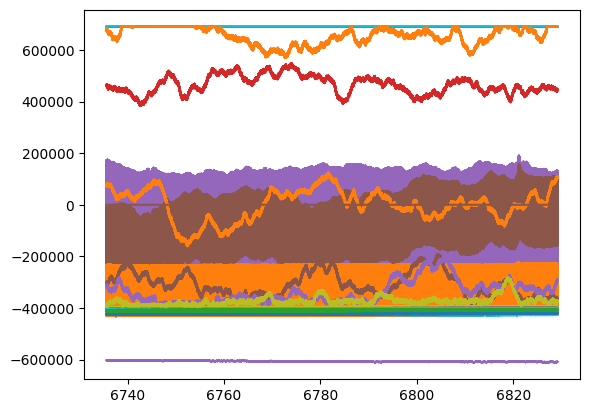

In [3]:
data, header = pyxdf.load_xdf("Tests0/KIKE_sub-P001_ses-S001_task-Default_run-001_eeg_old4.xdf")

for stream in data:
    y = stream['time_series']
    print(f"Name: {stream['info']['name']}")

    if isinstance(y, list):
        # list of strings, draw one vertical line for each marker
        for timestamp, marker in zip(stream['time_stamps'], y):
            plt.axvline(x=timestamp)
            print(f'Marker "{marker[0]}" @ {timestamp:.2f}s')
    elif isinstance(y, np.ndarray):
        # numeric data, draw as lines
        plt.plot(stream['time_stamps'], y)
    else:
        raise RuntimeError('Unknown stream format')

plt.show()

## Juan/Kike's Data

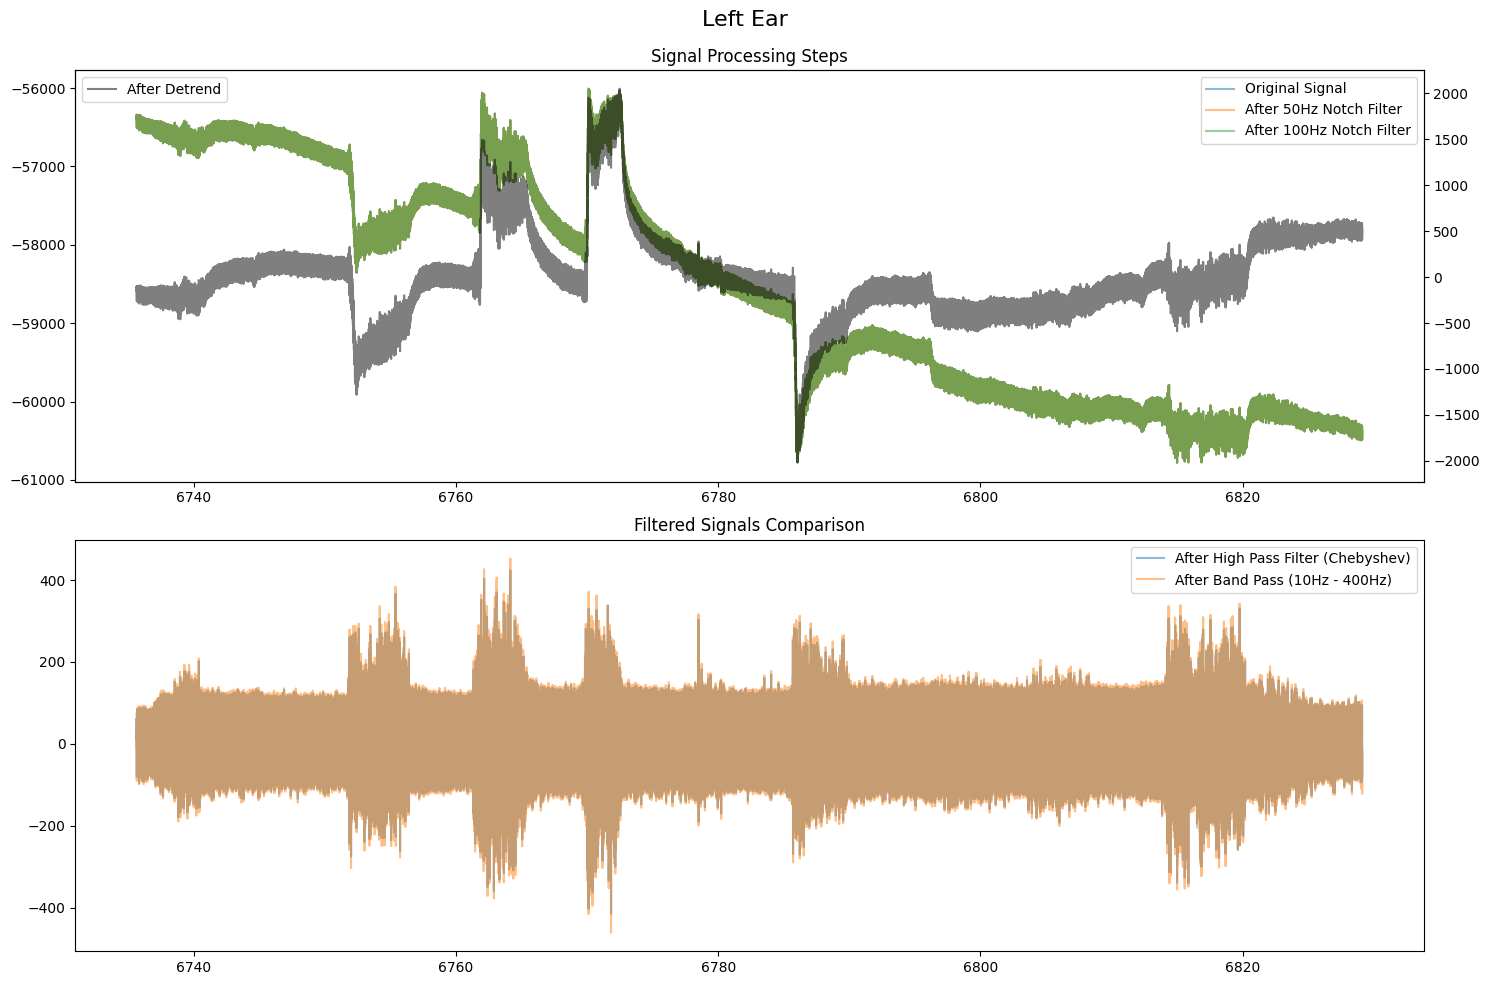

In [4]:
data, header = pyxdf.load_xdf("Tests0/KIKE_sub-P001_ses-S001_task-Default_run-001_eeg_old4.xdf")

fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # Create two plots

Fs = 2000

for stream in data:
    y = stream["time_series"]

    aux = y[:,0] - y[:,1]  # Left ear
    aux = NotchF(aux, Fs, 50, 5)
    aux = NotchF(aux, Fs, 100, 5)
    aux = NotchF(aux, Fs, 150, 5)
    aux = NotchF(aux, Fs, 200, 5)
    aux = NotchF(aux, Fs, 250, 5)

    aux2 = NotchF(aux, Fs, 300, 5)  # First notch filter at 150Hz
    aux3 = NotchF(aux2, Fs, 350, 5)  # Second notch filter at 250Hz
    aux4 = detrend(aux3)  # Detrended signal
    
    l_ear = HPF(input_signal=aux4, sr=Fs, cutoff=10, filter_type="cheb")  # High-pass filter
    l_bandpass = 10
    h_bandpass = 400
    l_ear_bandpass = bandpass_filter(aux4, Fs, l_bandpass, h_bandpass)  # Band-pass filter

    if isinstance(y, np.ndarray):
        # Plot original, 50Hz notch, 100Hz notch, and detrended signal with transparency on the first plot
        axes[0].plot(stream["time_stamps"], aux, label="Original Signal", alpha=0.5)
        axes[0].plot(stream["time_stamps"], aux2, label="After 50Hz Notch Filter", alpha=0.5)
        axes[0].plot(stream["time_stamps"], aux3, label="After 100Hz Notch Filter", alpha=0.5)
        axes0_twin = axes[0].twinx()  # Create a twin y-axis for the detrended signal
        axes0_twin.plot(stream["time_stamps"], aux4, label="After Detrend", color="black", alpha=0.5)
        
        # Plot l_ear and l_ear_bandpass on the second plot with transparency
        axes[1].plot(stream["time_stamps"], l_ear, label="After High Pass Filter (Chebyshev)", alpha=0.5)
        axes[1].plot(stream["time_stamps"], l_ear_bandpass, label=f"After Band Pass ({l_bandpass}Hz - {h_bandpass}Hz)", alpha=0.5)
        
        # Setting titles and legends
        axes[0].set_title("Signal Processing Steps")
        axes[1].set_title("Filtered Signals Comparison")
        axes[0].legend(loc="upper right")
        axes0_twin.legend(loc="upper left")
        axes[1].legend()

plt.tight_layout()  # Adjust layout to not overlap
plt.subplots_adjust(top=0.92)
plt.suptitle("Left Ear", fontsize=16)
plt.show()


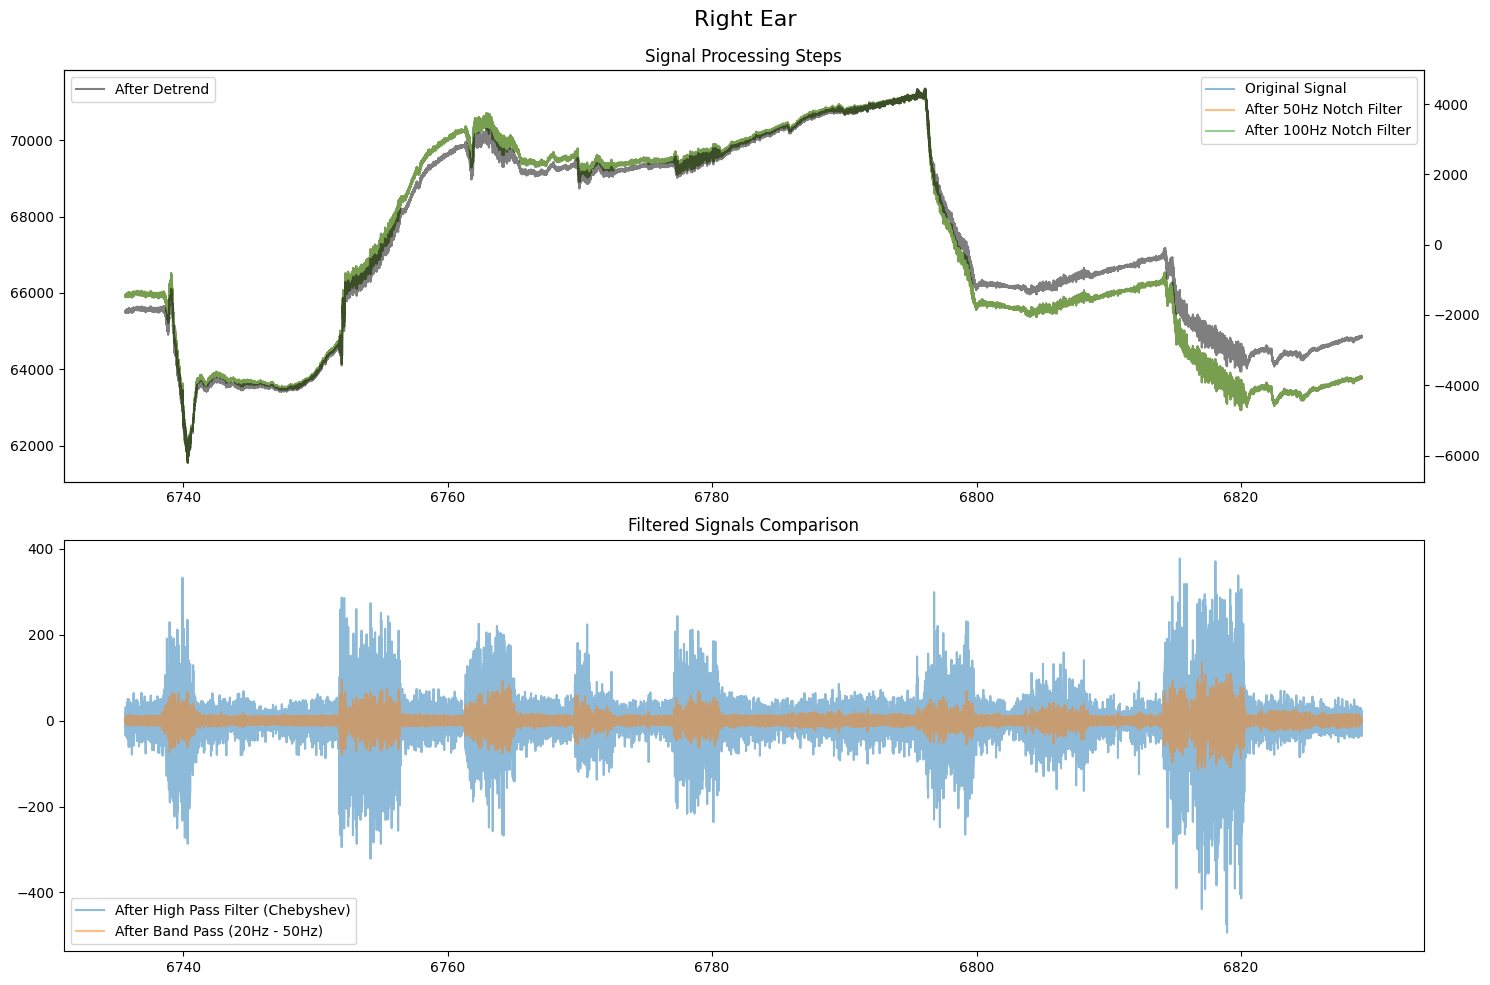

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # Create two plots

Fs = 2000

for stream in data:
    y = stream["time_series"]

    aux = y[:,2] - y[:,3]  # Right ear

    aux2 = NotchF(aux, Fs, 50, 5)  # First notch filter at 50Hz
    aux3 = NotchF(aux2, Fs, 100, 5)  # Second notch filter at 100Hz
    aux4 = detrend(aux3)  # Detrended signal
    
    r_ear = HPF(input_signal=aux4, sr=Fs, cutoff=10, filter_type="cheb")  # High-pass filter
    l_bandpass = 20
    h_bandpass = 50
    r_ear_bandpass = bandpass_filter(aux4, Fs, l_bandpass, h_bandpass)  # Band-pass filter

    if isinstance(y, np.ndarray):
        # Plot original, 50Hz notch, 100Hz notch, and detrended signal with transparency on the first plot
        axes[0].plot(stream["time_stamps"], aux, label="Original Signal", alpha=0.5)
        axes[0].plot(stream["time_stamps"], aux2, label="After 50Hz Notch Filter", alpha=0.5)
        axes[0].plot(stream["time_stamps"], aux3, label="After 100Hz Notch Filter", alpha=0.5)
        axes0_twin = axes[0].twinx()  # Create a twin y-axis for the detrended signal
        axes0_twin.plot(stream["time_stamps"], aux4, label="After Detrend", color="black", alpha=0.5)
        
        # Plot r_ear and r_ear_bandpass on the second plot with transparency
        axes[1].plot(stream["time_stamps"], r_ear, label="After High Pass Filter (Chebyshev)", alpha=0.5)
        axes[1].plot(stream["time_stamps"], r_ear_bandpass, label=f"After Band Pass ({l_bandpass}Hz - {h_bandpass}Hz)", alpha=0.5)
        
        # Setting titles and legends
        axes[0].set_title("Signal Processing Steps")
        axes[1].set_title("Filtered Signals Comparison")
        axes[0].legend(loc="upper right")
        axes0_twin.legend(loc="upper left")
        axes[1].legend()

plt.tight_layout()  # Adjust layout to not overlap
plt.subplots_adjust(top=0.92)
plt.suptitle("Right Ear", fontsize=16)
plt.show()


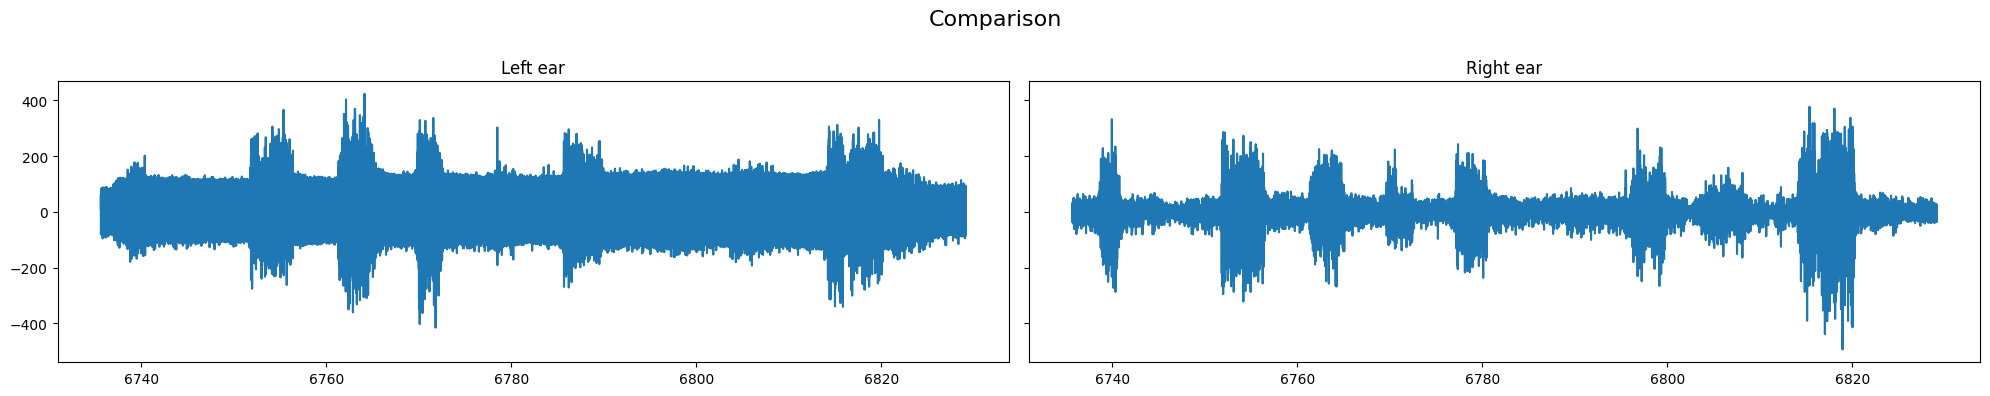

In [129]:
# Comparison between ears

fig, axes = plt.subplots(1,2,figsize=(20,4), sharey=True)
axes[0].plot(stream["time_stamps"], l_ear)
axes[0].set_title("Left ear")

axes[1].plot(stream["time_stamps"], r_ear)
axes[1].set_title("Right ear")

plt.tight_layout()
fig.suptitle("Comparison", fontsize=16)
plt.subplots_adjust(top=0.8)
plt.show()

## Alessandra's Data

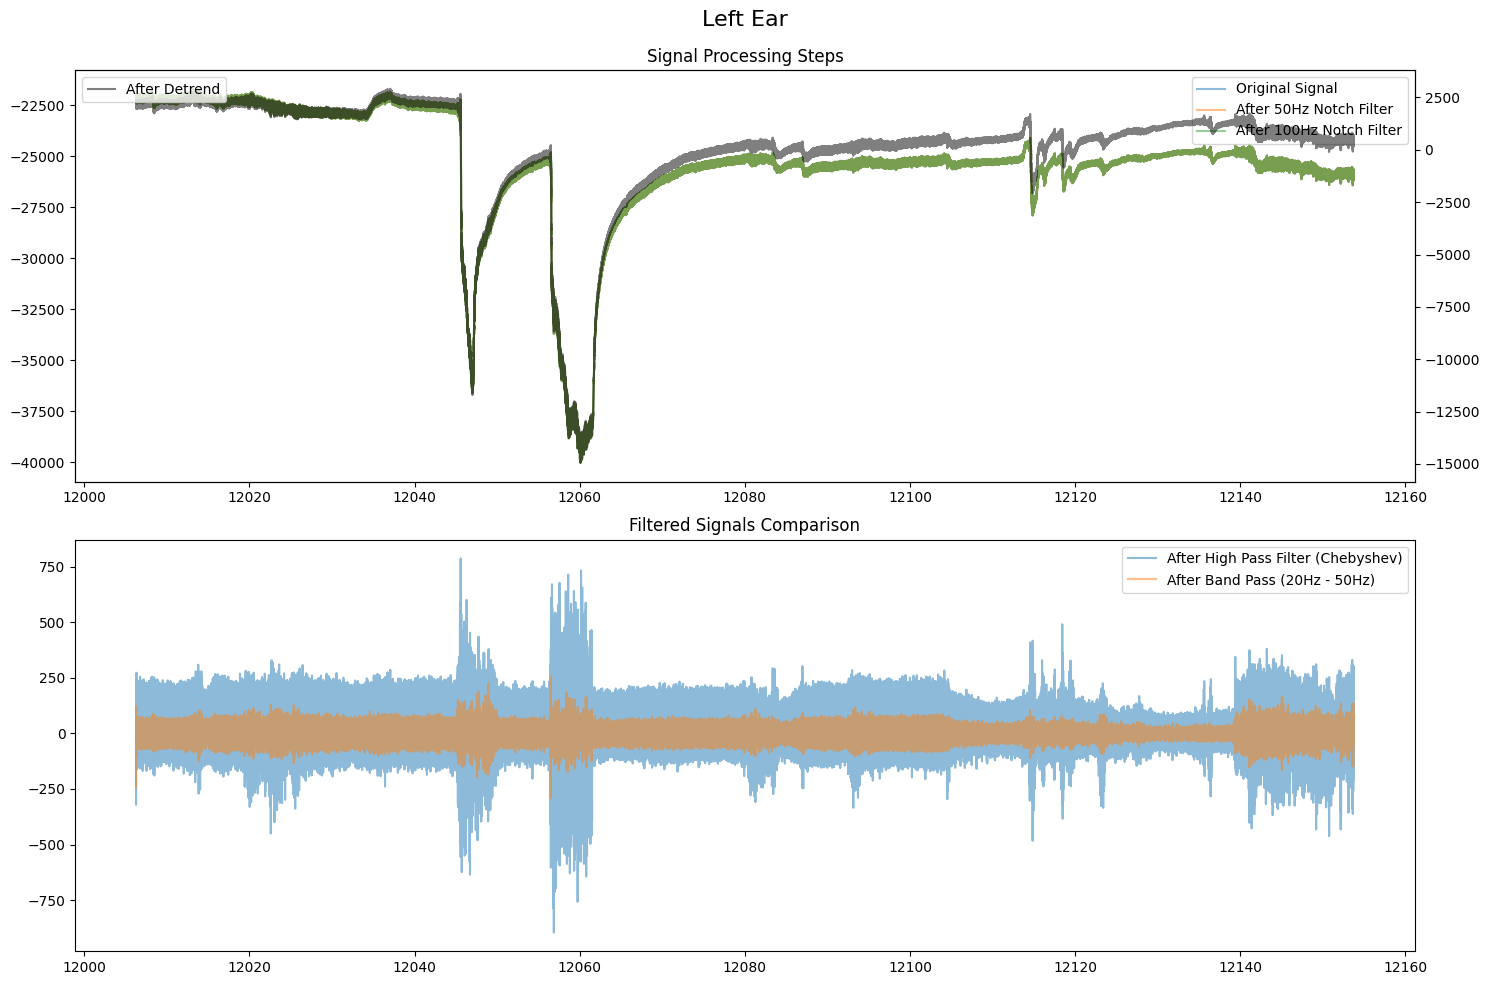

In [130]:
data, header = pyxdf.load_xdf("Tests0/ALE_sub-P001_ses-S001_task-Default_run-001_eeg.xdf")

fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # Create two plots

Fs = 2000

for stream in data:
    y = stream["time_series"]

    aux = y[:,0] - y[:,1]  # Left ear

    aux2 = NotchF(aux, Fs, 50, 5)  # First notch filter at 50Hz
    aux3 = NotchF(aux2, Fs, 100, 5)  # Second notch filter at 100Hz
    aux4 = detrend(aux3)  # Detrended signal
    
    l_ear = HPF(input_signal=aux4, sr=Fs, cutoff=10, filter_type="cheb")  # High-pass filter
    l_bandpass = 20
    h_bandpass = 50
    l_ear_bandpass = bandpass_filter(aux4, Fs, l_bandpass, h_bandpass)  # Band-pass filter

    if isinstance(y, np.ndarray):
        # Plot original, 50Hz notch, 100Hz notch, and detrended signal with transparency on the first plot
        axes[0].plot(stream["time_stamps"], aux, label="Original Signal", alpha=0.5)
        axes[0].plot(stream["time_stamps"], aux2, label="After 50Hz Notch Filter", alpha=0.5)
        axes[0].plot(stream["time_stamps"], aux3, label="After 100Hz Notch Filter", alpha=0.5)
        axes0_twin = axes[0].twinx()  # Create a twin y-axis for the detrended signal
        axes0_twin.plot(stream["time_stamps"], aux4, label="After Detrend", color="black", alpha=0.5)
        
        # Plot l_ear and l_ear_bandpass on the second plot with transparency
        axes[1].plot(stream["time_stamps"], l_ear, label="After High Pass Filter (Chebyshev)", alpha=0.5)
        axes[1].plot(stream["time_stamps"], l_ear_bandpass, label=f"After Band Pass ({l_bandpass}Hz - {h_bandpass}Hz)", alpha=0.5)
        
        # Setting titles and legends
        axes[0].set_title("Signal Processing Steps")
        axes[1].set_title("Filtered Signals Comparison")
        axes[0].legend(loc="upper right")
        axes0_twin.legend(loc="upper left")
        axes[1].legend()

plt.tight_layout()  # Adjust layout to not overlap
plt.subplots_adjust(top=0.92)
plt.suptitle("Left Ear", fontsize=16)
plt.show()


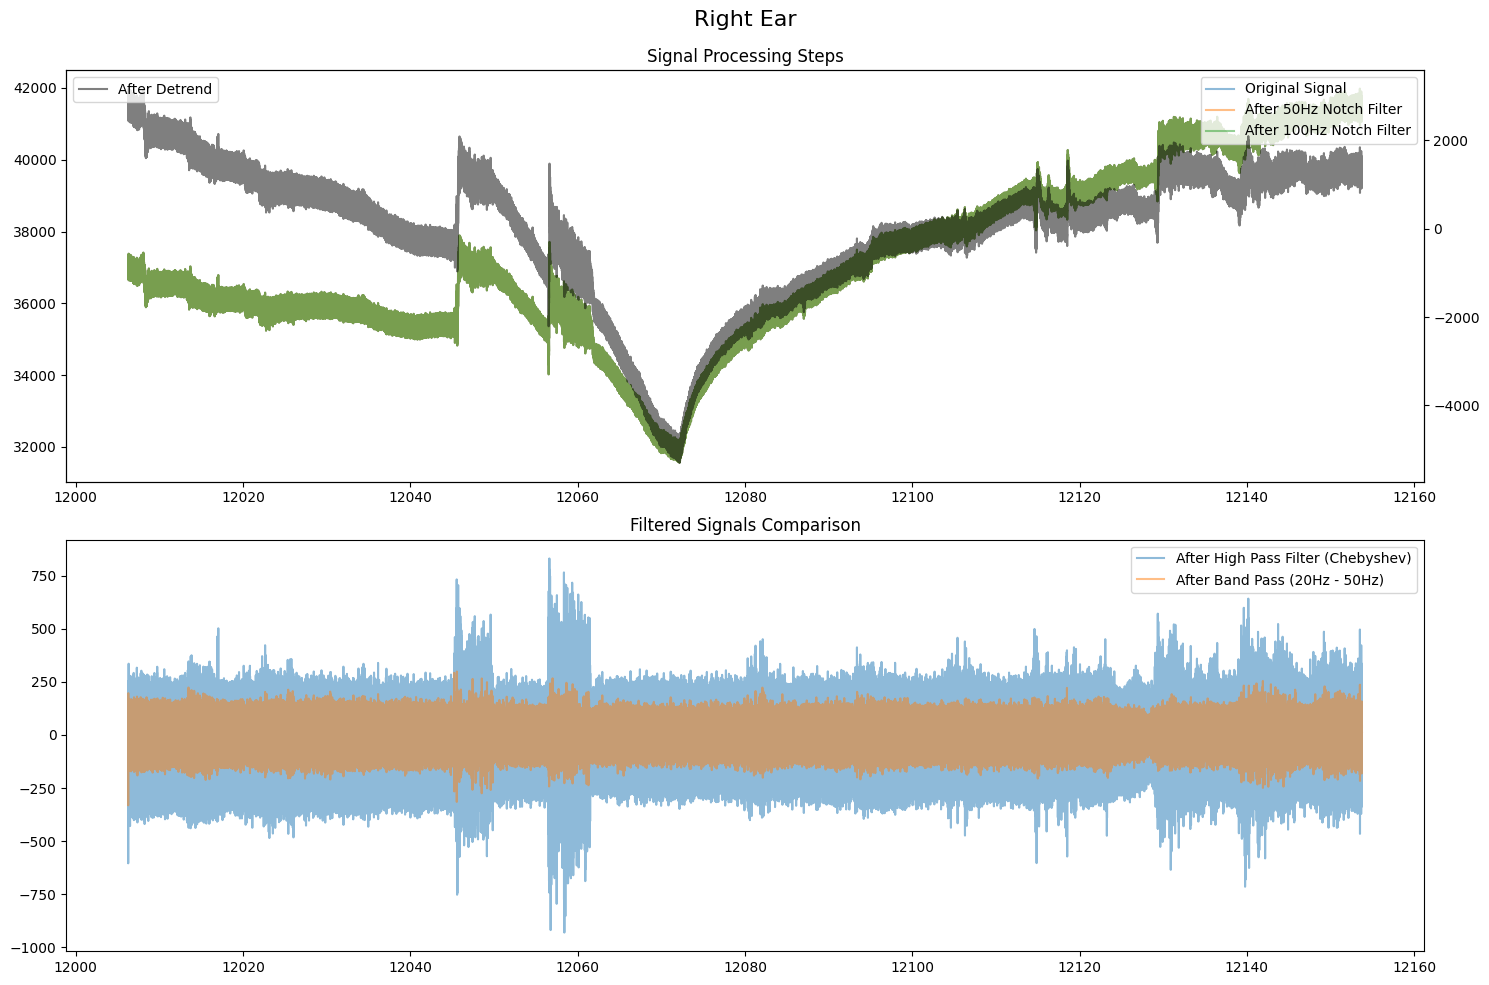

In [131]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # Create two plots

Fs = 2000

for stream in data:
    y = stream["time_series"]

    aux = y[:,2] - y[:,3]  # Rght ear

    aux2 = NotchF(aux, Fs, 50, 5)  # First notch filter at 50Hz
    aux3 = NotchF(aux2, Fs, 100, 5)  # Second notch filter at 100Hz
    aux4 = detrend(aux3)  # Detrended signal
    
    r_ear = HPF(input_signal=aux4, sr=Fs, cutoff=10, filter_type="cheb")  # High-pass filter
    l_bandpass = 20
    h_bandpass = 50
    r_ear_bandpass = bandpass_filter(aux4, Fs, l_bandpass, h_bandpass)  # Band-pass filter

    if isinstance(y, np.ndarray):
        # Plot original, 50Hz notch, 100Hz notch, and detrended signal with transparency on the first plot
        axes[0].plot(stream["time_stamps"], aux, label="Original Signal", alpha=0.5)
        axes[0].plot(stream["time_stamps"], aux2, label="After 50Hz Notch Filter", alpha=0.5)
        axes[0].plot(stream["time_stamps"], aux3, label="After 100Hz Notch Filter", alpha=0.5)
        axes0_twin = axes[0].twinx()  # Create a twin y-axis for the detrended signal
        axes0_twin.plot(stream["time_stamps"], aux4, label="After Detrend", color="black", alpha=0.5)
        
        # Plot r_ear and r_ear_bandpass on the second plot with transparency
        axes[1].plot(stream["time_stamps"], r_ear, label="After High Pass Filter (Chebyshev)", alpha=0.5)
        axes[1].plot(stream["time_stamps"], r_ear_bandpass, label=f"After Band Pass ({l_bandpass}Hz - {h_bandpass}Hz)", alpha=0.5)
        
        # Setting titles and legends
        axes[0].set_title("Signal Processing Steps")
        axes[1].set_title("Filtered Signals Comparison")
        axes[0].legend(loc="upper right")
        axes0_twin.legend(loc="upper left")
        axes[1].legend()

plt.tight_layout()  # Adjust layout to not overlap
plt.subplots_adjust(top=0.92)
plt.suptitle("Right Ear", fontsize=16)
plt.show()


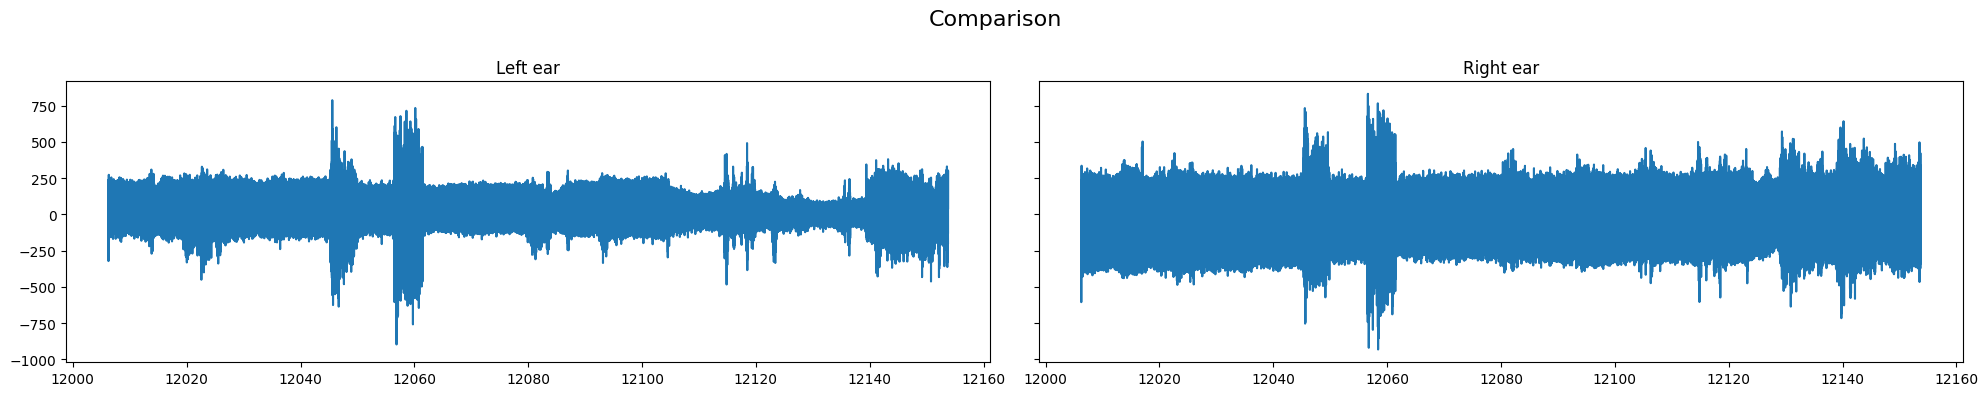

In [132]:
# Comparison between ears

fig, axes = plt.subplots(1,2,figsize=(20,4), sharey=True)
axes[0].plot(stream["time_stamps"], l_ear)
axes[0].set_title("Left ear")

axes[1].plot(stream["time_stamps"], r_ear)
axes[1].set_title("Right ear")

plt.tight_layout()
fig.suptitle("Comparison", fontsize=16)
plt.subplots_adjust(top=0.8)
plt.show()

Conculsions:
- Notch filters don't do anything
- Band-pass filter is not necessary, the high pass filter is enough